### Importar Librerías Necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2

### Implementacion SVM

In [2]:
def svm_sgd(X, y, C=1, lr=0.001, epochs=100):
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    losses = []

    for epoch in range(epochs):
        # Calculamos la pérdida y el gradiente
        distances = 1 - y * (np.dot(X, w) + b)
        dw = np.zeros(n)
        db = 0
        loss = 0

        for i, d in enumerate(distances):
            if d > 0:
                dw += -C * y[i] * X[i]
                db += -C * y[i]
                loss += d
            else:
                dw += 0
                db += 0
        # Añadir la regularización
        dw = w + dw / m
        db = db / m
        loss = 0.5 * np.dot(w, w) + C * loss / m

        # Actualizar los pesos
        w -= lr * dw
        b -= lr * db

        losses.append(loss)

    return w, b, losses

## Cargar y Preparar las Imágenes de Entrenamiento

### Función para Cargar una Imagen y Extraer los Píxeles

In [3]:
def load_image_pixels(image_path):
    image = Image.open(image_path)
    pixels = np.array(image)
    return pixels

# Función para cargar y convertir los píxeles al espacio HSV
def load_image_pixels_hsv(image_path):
    image = Image.open(image_path)
    image_np = np.array(image)
    # Convertir de RGB a HSV
    image_hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
    return image_hsv

### Cargar las Imágenes y Extraer los Píxeles

In [4]:
# Cargar imágenes
cow_pixels_hsv = load_image_pixels_hsv('../images/train/vaca.jpg')
grass_pixels_hsv = load_image_pixels_hsv('../images/train/pasto.jpg')
sky_pixels_hsv = load_image_pixels_hsv('../images/train/cielo.jpg')

### Preparar los Datos y Etiquetas

In [8]:
# Función para convertir los píxeles en una matriz de características y etiquetas
def prepare_data(cow_pixels, grass_pixels, sky_pixels):
    # Aplanar las matrices de píxeles y extraer las características HSV
    X_cow = cow_pixels.reshape(-1, 3)
    X_grass = grass_pixels.reshape(-1, 3)
    X_sky = sky_pixels.reshape(-1, 3)
    
    # Crear etiquetas
    y_cow = np.ones(X_cow.shape[0])       # Clase +1 para 'vaca'
    y_grass = -np.ones(X_grass.shape[0])  # Clase -1 para 'no vaca' (pasto)
    y_sky = -np.ones(X_sky.shape[0])      # Clase -1 para 'no vaca' (cielo)
    
    # Combinar los datos y etiquetas
    X = np.vstack((X_cow, X_grass, X_sky))
    y = np.hstack((y_cow, y_grass, y_sky))
    
    return X, y

### Entrenar

In [9]:
X_train, y_train = prepare_data(cow_pixels_hsv, grass_pixels_hsv, sky_pixels_hsv)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
lr_values = [0.001, 0.01, 0.1, 1]

results = []

for C in C_values:
    for lr in lr_values:
        w, b, _ = svm_sgd(X_train, y_train, C=C, lr=lr, epochs=100)
        results.append((C, lr, w, b))

### Cargar la Imagen Compuesta y Preparar los Píxeles para Clasificar

In [10]:
# Cargar la imagen compuesta
composite_image = Image.open('../images/cow.jpg')  # Reemplaza con el nombre de tu imagen
composite_pixels = np.array(composite_image)
composite_pixels_hsv = cv2.cvtColor(composite_pixels, cv2.COLOR_RGB2HSV)

# Aplanar los píxeles para clasificarlos
X_test_hsv = composite_pixels_hsv.reshape(-1, 3)


### Aplicar el Modelo para Clasificar Cada Píxel

In [11]:
# Función de predicción
def svm_predict_pixel(X, w, b):
    return np.sign(np.dot(X, w) + b)

# Predecir las clases de los píxeles
preds = []
for model in results:
    w = model[2]
    b = model[3]
    preds.append(svm_predict_pixel(X_test_hsv, w, b))


### Generar la Máscara de Segmentación

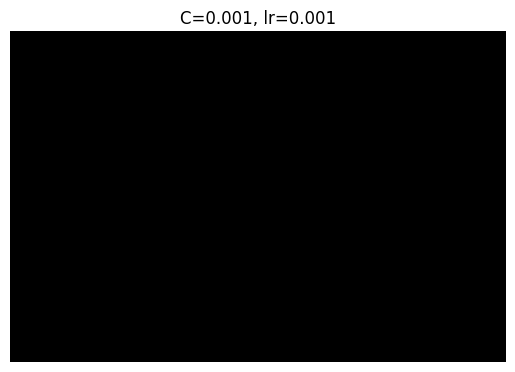

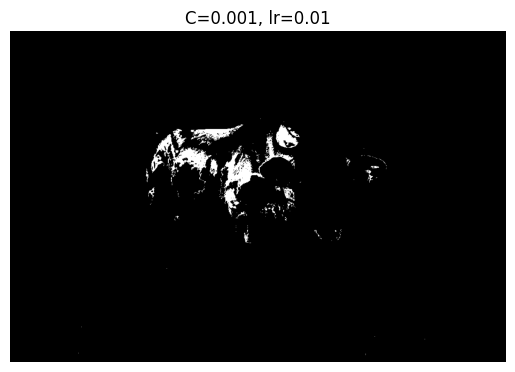

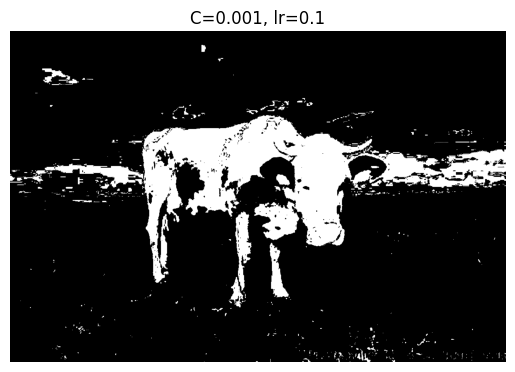

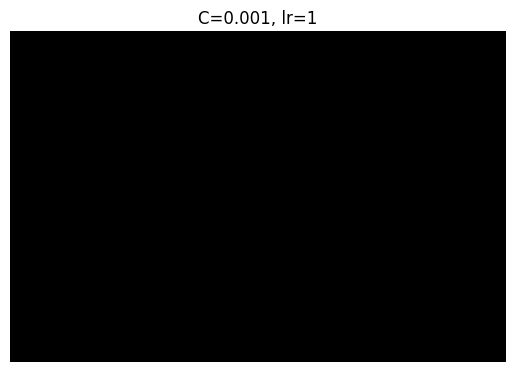

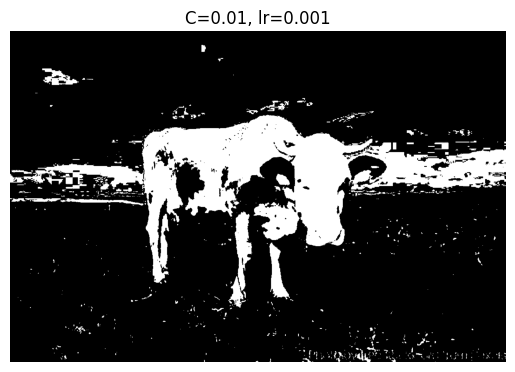

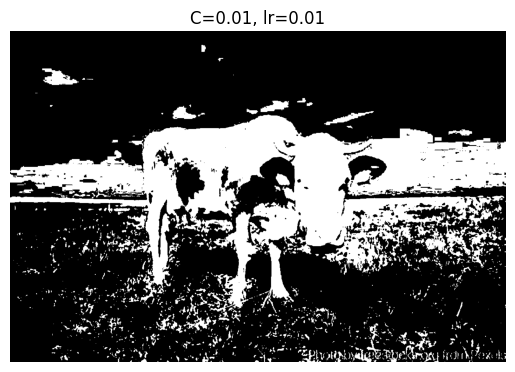

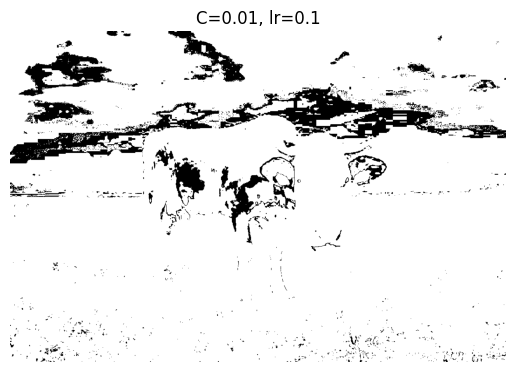

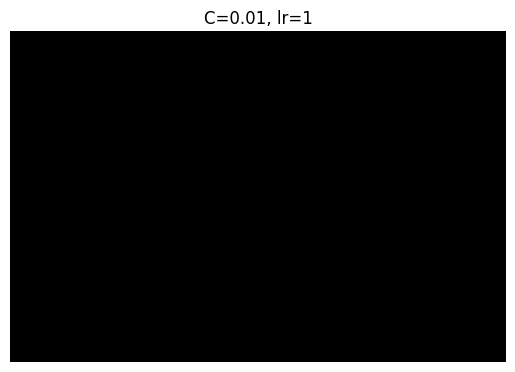

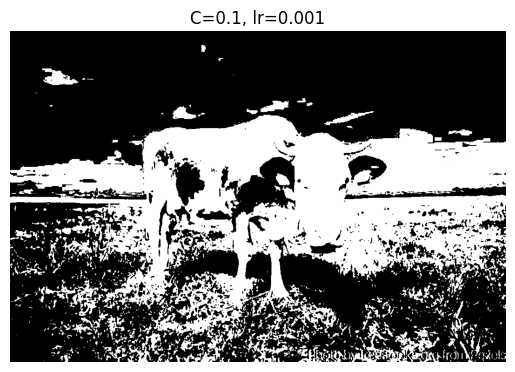

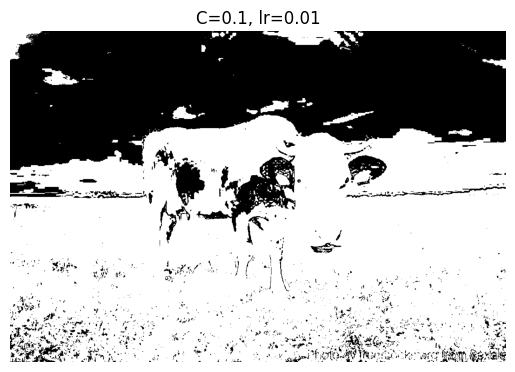

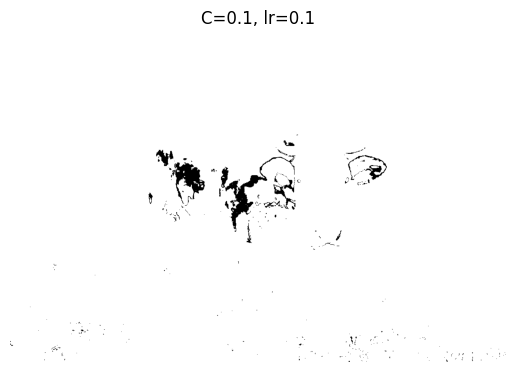

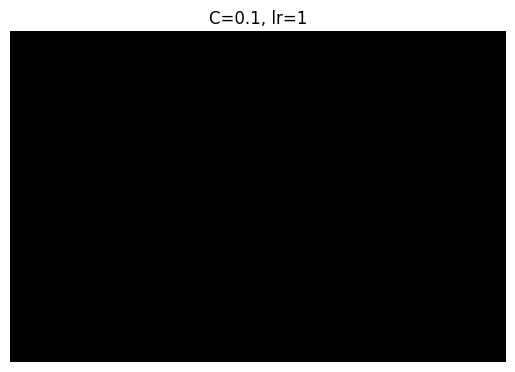

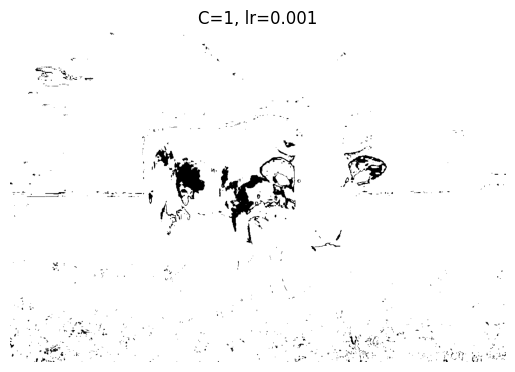

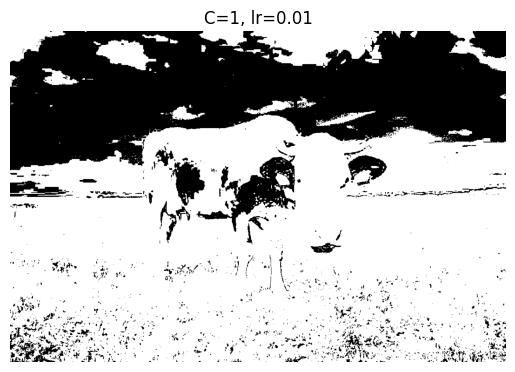

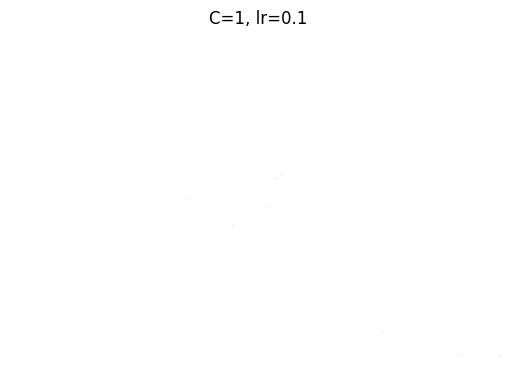

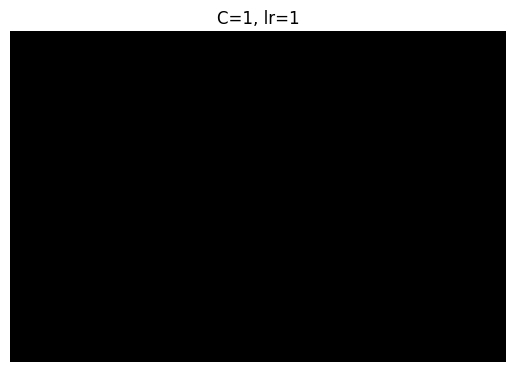

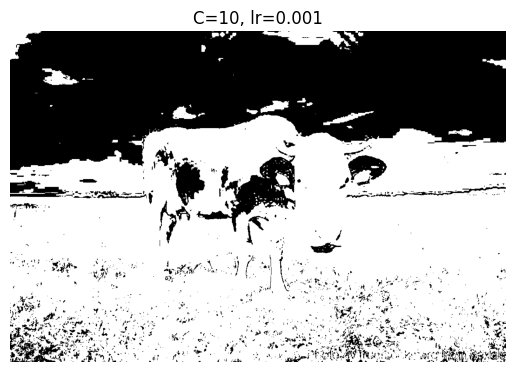

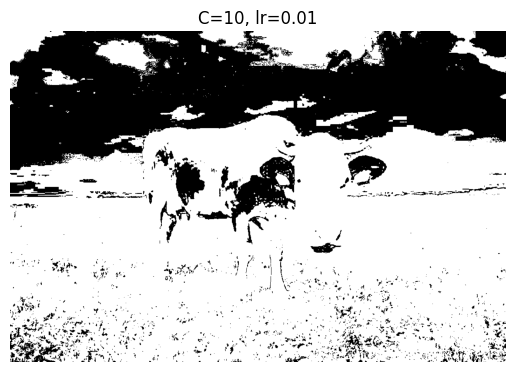

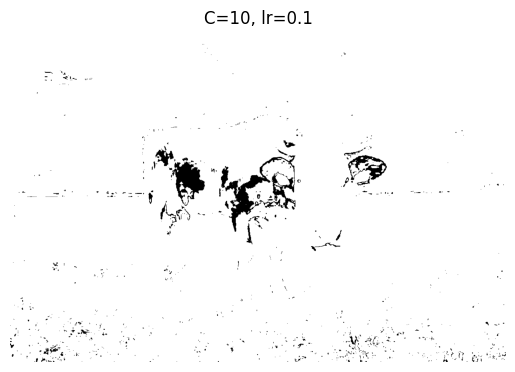

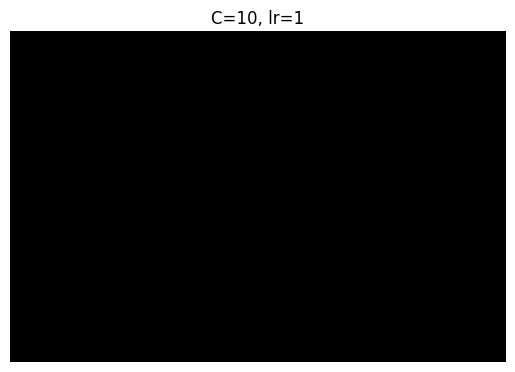

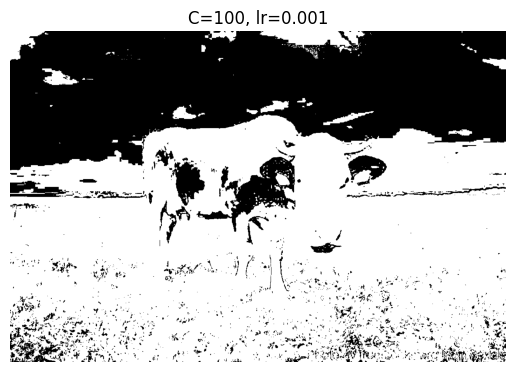

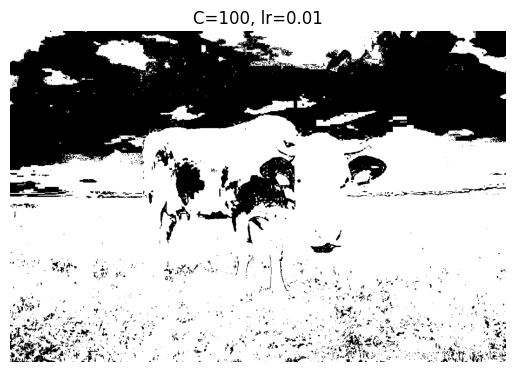

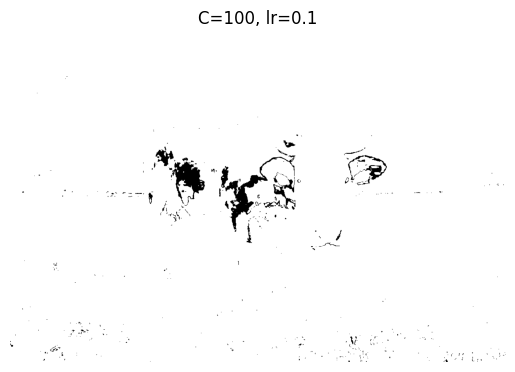

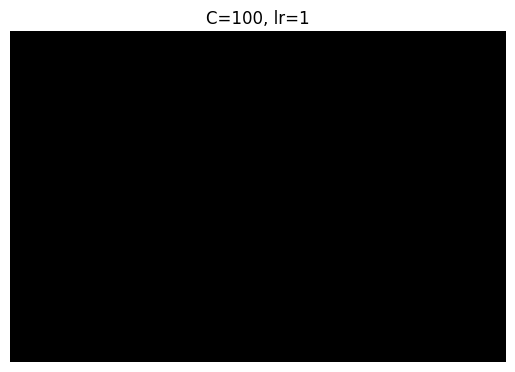

In [12]:
for i, pred in enumerate(preds):
    y_pred = pred.reshape(composite_pixels.shape[0], composite_pixels.shape[1])
    plt.imshow(y_pred, cmap='gray')
    C, lr, _, _ = results[i]
    plt.title(f'C={C}, lr={lr}')
    plt.axis('off')
    plt.show()
